
## Project data science  : Clustering_ Prediction

Objectifs :
réaliser à partir d'un dataset les taches suivantes :

- Clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- Prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    
    lien https://github.com/amineHY/prediction_employer_dataset/blob/master/script.py

In [1]:
#-LIBRARY CALL
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
#plt.style.use('ggplot')
%matplotlib notebook


## Exploratory Data Analysis

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


In [4]:
print("Cette base de données contient {} observations \n".format(df.shape[0]))
print("le nombre des valeus manquantes par features : \n{}".format(df.isna().sum()))


Cette base de données contient 9582 observations 

le nombre des valeus manquantes par features : 
Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


#### Imputation des valeurs manquantes pour la variable "Experience" avec :
     la valeur médiane pour les data scientists
     la valeur moyenne pour les data engineers

In [5]:
df = pd.read_csv('data.csv')
def fill_na(df):
    df['Exp_float']=df['Experience'].str.replace(',','.').astype('float')
    median_Exp =df['Exp_float'].median()  
    mean_Exp =df['Exp_float'].mean()
    df.loc[(df.Metier=='Data scientist') & (df.Exp_float.isna()), 'Exp_float']=median_Exp
    df.loc[(df.Metier=='Data engineer') & (df.Exp_float.isna()), 'Exp_float']=mean_Exp
    
    return df
df=fill_na(df)
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_float
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris,1.0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille,3.0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes,3.0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille,1.5
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux,2.0


In [6]:
df['Exp_float'].isna().sum()

42

In [7]:
# les années d'experienceen moyen des profils data scientist, lead data scientist et data engineer
exp=df.groupby('Metier').agg({'Exp_float':'mean'})

print('''la moyenne des années d'experiences pour les Data scientist est %.2f''' %exp.loc['Data scientist'][0] )
print('''la moyenne des années d'experiences pour les Lead data scientist est %.2f'''%exp.loc['Lead data scientist'][0]) 
print('''la moyenne des années d'experiences pour les Data engineer est %.2f'''   %exp.loc['Data engineer'][0]) 
print('''la moyenne des années d'experiences pour les Data architect est %.2f'''   %exp.loc['Data architecte'][0]) 


la moyenne des années d'experiences pour les Data scientist est 2.24
la moyenne des années d'experiences pour les Lead data scientist est 3.97
la moyenne des années d'experiences pour les Data engineer est 2.98
la moyenne des années d'experiences pour les Data architect est 3.00


<IPython.core.display.Javascript object>


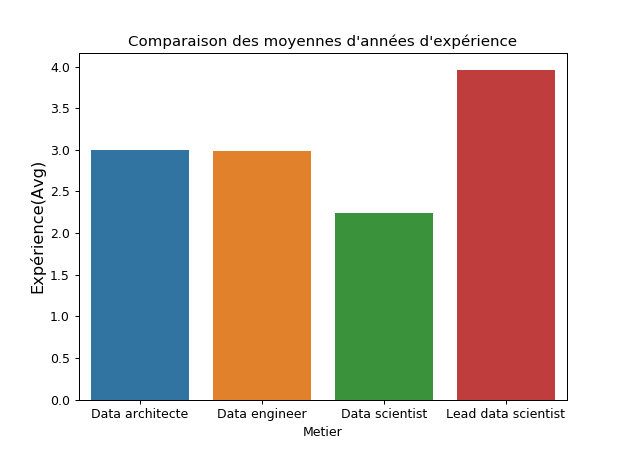

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [8]:
plt.figure(figsize=(7,5))
ax=sb.barplot(exp.index,exp['Exp_float'],)
ax.set_title('''Comparaison des moyennes d'années d'expérience''',)
ax.set_ylabel('Expérience(Avg)',fontsize=13)
plt.xticks(fontsize=10)

### Transformation dela variable continue 'Experience' en  variable catégorielle 'Exp_label':

In [9]:
# Transformation dela variable continue 'Experience' en  variable catégorielle 'Exp_label':
#avec 4 catégories (débutant, confirmé, avancé et expert)
df['Exp_label']=pd.cut(df.Exp_float,bins=4,labels=['débutant', 'confirmé', 'avancé' , 'expert'])
df.Exp_label.value_counts()

débutant    8438
confirmé     861
avancé       189
expert        52
Name: Exp_label, dtype: int64

### les 5 technologies les plus utilisées

<IPython.core.display.Javascript object>


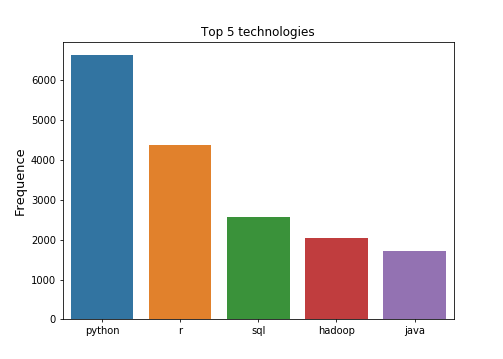

Text(0, 0.5, 'Frequence')

In [10]:
myserie= df.Technologies.str.lower()
mylist=[]
for i in range(df.shape[0]):
    [mylist.append(w) for w in df.Technologies[i].lower().split('/')] 
    
myS=pd.Series(mylist)
myS.replace({'hadoop(hdfs)':'hadoop','hdfs':'hadoop'},inplace=True)

fig,ax=plt.subplots(figsize=(7,5),dpi=80)
ax=sb.barplot(myS.value_counts()[0:5].index,myS.value_counts()[0:5].values)

ax.set_title('''Top 5 technologies''',)
ax.set_ylabel('Frequence',fontsize=13)


In [11]:
df.Metier

0            Data scientist
1           Data architecte
2       Lead data scientist
3            Data scientist
4            Data scientist
               ...         
9577         Data scientist
9578         Data scientist
9579         Data scientist
9580         Data scientist
9581         Data scientist
Name: Metier, Length: 9582, dtype: object

## Clustering non supervisée : 2 clusters

In [13]:
# Import du dataframe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('data.csv')

df=fill_na(df) #function above

df['Technologies'].replace(regex={'HADOOP\(HDFS\)': 'HADOOP', 'HDFS': 'HADOOP'}, inplace=True)
## Vectorisation des technologies dans df_vect_tech
Count_V = CountVectorizer(token_pattern=r"[^/]+")
vect_tech= Count_V.fit_transform(df.Technologies.values)
mydf=df_vect_tech=pd.DataFrame(vect_tech.toarray(),columns=Count_V.get_feature_names())

#Encoding 
LabEncod=LabelEncoder()
mydf['Diplome']=pd.Series(LabEncod.fit_transform(df.Diplome))
mydf['Metier']=pd.Series(LabEncod.fit_transform(df.Metier.astype('str')))


# Normalisation
scaler=MinMaxScaler()
mydf['Diplome']=pd.Series(np.squeeze(scaler.fit_transform((mydf.Diplome.values[:,np.newaxis]))))
mydf['Metier']=pd.Series(np.squeeze(scaler.fit_transform((mydf.Metier.values[:,np.newaxis]))))
mydf['Exp_float']=pd.Series(np.squeeze(scaler.fit_transform((df.Exp_float.values[:,np.newaxis]))))
mydf.dropna(inplace=True)

mydf


,ai,anglais,aws,big data,c,c++,cassandra,deep learning,docker,elasticsearch,...,tableau,tensorflow,teradata,vba,vertica,windows,yarn,Diplome,Metier,Exp_float
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.333333,0.50,0.047619
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.00,0.142857
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0.333333,0.75,0.142857
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.50,0.071429
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1.000000,0.50,0.095238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.50,0.071429
9578,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.50,0.523810
9579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.333333,0.50,0.047619
9580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0.50,0.809524


<IPython.core.display.Javascript object>


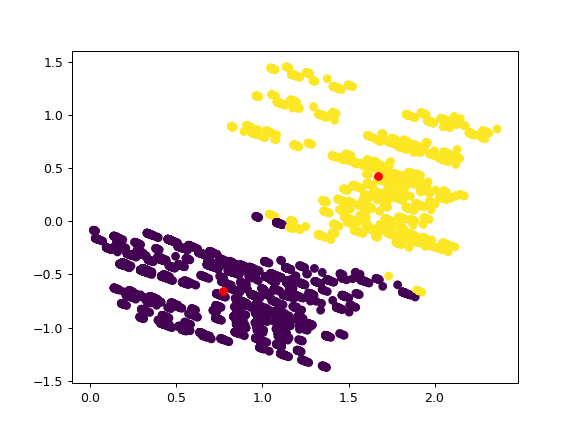

In [14]:
## Reduction de dimension de mydf afin de tracer les données sur un graphique 2D.
# Ici TruncatedSVD est utilisé à la place de PCA car mydf est une matrice creuse.

TSVD=TruncatedSVD(n_components=2).fit(mydf)
mydf_reduced=TSVD.transform(mydf)
mydf_reduced

## Construction du modèle K-means à 2 clusters. 
kmns=KMeans(n_clusters=2)
kmns.fit_transform(mydf_reduced)
plt.figure()
plt.scatter(mydf_reduced[:,0],mydf_reduced[:,1],c=kmns.predict(mydf_reduced))
plt.scatter(kmns.cluster_centers_[:,0],kmns.cluster_centers_[:,1],c='r')

In [15]:
kmns.predict(mydf_reduced)
kmns.cluster_centers_

array([[ 0.7724273 , -0.65626888],
       [ 1.67404131,  0.4228413 ]])

In [621]:
mydf

,ai,anglais,aws,big data,c,c++,cassandra,deep learning,docker,elasticsearch,...,sql,tableau,tensorflow,teradata,vba,vertica,windows,yarn,Exp_float,Diplome
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.047619,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.142857,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0.142857,1
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.071429,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0.095238,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9577,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.071429,1
9578,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.523810,1
9579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.047619,1
9580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.809524,1


In [512]:
np.squeeze(df.loc[:, ['Technologies']])

0           Matlab/Python/Pyspark/Scikit-learn/Tensorflow
1                               Python/Java/Scala/MongoDB
2       SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...
3                                       C/C++/Java/Python
4         Matlab/Python/C++/numpy/Tensorflow/scikit-learn
                              ...                        
9577                       C++/R/Python/Matlab/Matplotlib
9578       Excel/Python/Matlab/R/machine learning/anglais
9579                         R/machine learning/Excel/VBA
9580      Python/Pyspark/machine learning/Microsoft Azure
9581                                   VBA/Python/Excel/R
Name: Technologies, Length: 9582, dtype: object

In [1]:

# coding: utf-8

#
# ## Projet data science
#
# Objectifs:
# - clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
# - prédiction des profils dont le métier n'est pas labellisé
#
#
# ## Données
# data.csv contient 6 variables :
#     - 'Entreprise' correspond à une liste d'entreprises fictive
#     - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
#     - 'Technologies' correspond aux compétences maîtrisées par le profil
#     - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
#     - 'Experience' correspond au nombre d'années d'expériences
#     - 'Ville' correspond au lieu de travail
#
#

# In[1]:


# Import des libraries classique (numpy, pandas, ...)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from __future__ import division
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')


# ### Importation et analyse de la dataset

# In[2]:


# Import du dataframe "data.csv"
df = pd.read_csv('./data.csv', sep=',')
df_orig = df


# In[3]:


print("Cette base de données contient {0:d} observations \n".format(
    df.shape[0]))
print("Voici le sommes des valeus manquantes par features : ")
print(df.isna().sum())
df.head(10)


# ### imputation des valeurs manquantes pour la variable "Experience" avec :
# - la valeur médiane pour les data scientists
# - la valeur moyenne pour les data engineers

# In[4]:


# convertir les chiffres dans le tableau en float et remplacer les ',' par des '.'
df['Experience'] = df['Experience'].apply(lambda x: float(
    re.sub(",", ".", x)) if isinstance(x, str) else x)


# remplire les valeurs manquantes de DE
mask_nan_de = df['Metier'] == 'Data engineer'
mean_de = df[mask_nan_de]['Experience'].dropna().mean()
df.loc[mask_nan_de, 'Experience'] = df.loc[mask_nan_de,
                                           'Experience'].fillna(mean_de)

# remplire les valeurs manquantes de DS
mask_nan_ds = df['Metier'] == 'Data scientist'
median_ds = df[mask_nan_ds]['Experience'].dropna().median()
mean_ds = df[mask_nan_ds]['Experience'].dropna().mean()
df.loc[mask_nan_ds, 'Experience'] = df.loc[mask_nan_ds,
                                           'Experience'].fillna(median_ds)

# remplire les valeurs manquantes de LDS
mask_nan_lds = df['Metier'] == 'Lead data scientist'
mean_lds = df[mask_nan_lds]['Experience'].dropna().mean()
df.loc[mask_nan_lds, 'Experience'] = df.loc[mask_nan_lds,
                                            'Experience'].fillna(mean_lds)

# remplire les valeurs manquantes de DA
mask_nan_da = df['Metier'] == 'Data architecte'
mean_da = df[mask_nan_da]['Experience'].dropna().mean()
df.loc[mask_nan_da, 'Experience'] = df.loc[mask_nan_da,
                                           'Experience'].fillna(mean_da)

print("Vérifiation des valeurs manquantes dans Experience : {0:d}.\n".format(
    df['Experience'].isna().sum()))


# ### Années d'expériences en moyenne pour chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne

# In[5]:


print("Les profils ont en moyenne:\n")
print("Lead data scientist : {0:f} d'années d'experiences".format(mean_lds))
print("Data architecte     : {0:f} ".format(mean_da))
print("Data enginner       : {0:f} ".format(mean_de))
print("Data scientist      : {0:f} ".format(mean_ds))


# ### Représentation graphique : nombre moyen d'années d'expériences pour chaque métier

# In[6]:


moy_all = [mean_ds, mean_de, mean_da, mean_lds]


def add_percentge(ax, x=0.5, y=0.25, direction='horizontal'):
    totals = []
    if direction == 'horizontal':
        for i in ax.patches:
            totals.append(i.get_width())
        total = np.sum(totals)
        for i in ax.patches:
            str_percentage = str(round((i.get_width()/total)*100, 2))+'%'
            ax.text(i.get_width()+x, i.get_y()+y,
                    str_percentage, weight='bold', color='black')

    elif direction == 'vertical':
        for i in ax.patches:
            totals.append(i.get_height())
        total = np.sum(totals)
        for i in ax.patches:
            str_percentage = str(round((i.get_height()/total)*100, 2))+'%'
            ax.text(i.get_x()+x, i.get_height()+y,
                    str_percentage,  weight='bold', color='black')


plt.figure(figsize=(15, 20))
plt.subplot(311),
ax = pd.Series(moy_all, index=df['Metier'].value_counts().keys()).plot(
    kind='barh')
add_percentge(ax, x=-0.4, y=0.25)
plt.xlabel("Annee d'experiences en moyenne")

# quelques graphes illustratifs
plt.subplot(323),
#pd.Series(df['Experience'].value_counts().values, df['Experience'].value_counts().keys()).plot.barh()
ax = df['Experience'].value_counts().plot(kind='barh')
add_percentge(ax), ax.invert_yaxis()
plt.xlabel("# de profile")
plt.ylabel("# d'annee d'experience")

plt.subplot(324),
ax = df['Ville'].value_counts().plot(kind='barh')
add_percentge(ax)
plt.xlabel("# de profile")
ax.invert_yaxis()

plt.subplot(325),
ax = pd.Series(df['Diplome'].value_counts()).plot(kind='barh')
add_percentge(ax, x=-600, y=0.25)
plt.xlabel("# de profile")
ax.invert_yaxis()

plt.subplot(326),
ax = pd.Series(df['Metier'].value_counts().values,
               index=df['Metier'].value_counts().keys()).plot.barh()
add_percentge(ax, x=-1000.5, y=0.25)
plt.xlabel("# de profile")
plt.subplots_adjust(wspace=0.3, hspace=0.2)
ax.invert_yaxis()


# ### Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert

# In[7]:


Exp_level = pd.cut(df['Experience'], bins=4, labels=(
    "Débutant", "Confirmé", "Avancé", "Expert"))
df["Exp_level"] = pd.Series(Exp_level, index=df.index)


# Affichage des résultats
ax = pd.Series(df['Exp_level'].value_counts(
).values, index=df['Exp_level'].value_counts().keys()).plot.barh(figsize=(10, 7))
add_percentge(ax, x=+10.5, y=0.25)
plt.xlabel("# de profile")
plt.subplots_adjust(wspace=0.3, hspace=0.2)
ax.invert_yaxis()


# ### les 5 technologies les plus utilisées

# In[8]:


top_5_tech = df['Technologies'].value_counts()[0:5]
print("Le top 5 des technologies les plus utilisés sont: \n",)
print(top_5_tech)
print("\n")

# Affichage de résultat
ax = top_5_tech.plot(kind='barh', figsize=(10, 7))
ax.invert_yaxis()
plt.xlabel("# de profile")


# ### Clustering non supervisée
#

# In[9]:


print("Avant d'aborder le clustering des données; il est necessaire de coder les chaines de caractetères en pour pouvoir mener le calculs par la suite.")
print("\nAvant: ")
print(df.head(10))

print("\n Après: ")
le = preprocessing.LabelEncoder()
# df_enc =

df_enc = df.loc[:, ['Experience']]
df_enc['Ville_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:, ['Ville']])[:]), index=df_enc.index)
df_enc['Technologies_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:, ['Technologies']])[:]), index=df_enc.index)
df_enc['Diplome_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:, ['Diplome']])[:]), index=df_enc.index)
df_enc['Exp_level_enc'] = pd.Series(le.fit_transform(np.squeeze(df.loc[:, ['Exp_level']])[:]), index=df_enc.index)

df_enc = np.round(df_enc, 2)
print(df_enc.head(10))
print(df_enc.info())


# In[10]:


X = df_enc.astype(float)

# feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, max_iter=100, algorithm='auto')
kmeans.fit(X_scaled)
labels_ = kmeans.labels_


# Evaluation de l'erreur de clustering
c1, c2 = kmeans.cluster_centers_


def NMSE(a, b): return 100 * ((a-b)**2).sum() / ((a)**2).sum()


# NMSE() (X_scaled[y_pred==1]  - c2)**2).sum() / ((X_scaled[y_pred==1] )**2).sum()*100
quad_dist1 = NMSE(X_scaled[labels_ == 0], c1)
# (X_scaled[y_pred==0]  - c1)**2).sum() / ((X_scaled[y_pred==0] )**2).sum()*100
quad_dist2 = NMSE(X_scaled[labels_ == 1], c2)
print('La méthode choisi pour le clustering est K-Means, pour sa simplicité et la connaissance du nombre de cluster')
print('La métrique utilisée est l"erreur moyenne quadratique normalisée par rapports pour chaque cluster: {0:2.2f}% et {1:2.2f} %'.format(
    quad_dist1, quad_dist2))

print("les erreurs de clustering obtenus sont < 20% ")
print(" \n Les caracteristiques imortantes des deux clusters sont le 'Diplome' et l'Experience'.       \n 'Master' & 'Bachelor' pour le premier cluster et 'No diplome' & 'PhD' pour le deuxieme cluster.       \n De plus, le nombre d'Experience des profiles du premier cluster est beaucoup plus élevés par rapport aux profiles du deuxieme cluster. ")
print("On remarque aussi que deux technologies revient pus souvent dans le cluster 2 qui sont : ")
print(df.loc[labels_ == 0, 'Technologies'].value_counts()[0:2])
print('Tandis que les technologies sont répartis uniformement pour le premier cluster.')
print("Le résultats de ce clustering porte un sens tout à fait logique et les figures l'illustre très bien.")

# Affichage des résultats
print("\n Affichage des caractéristiques du premier cluster : \n")
plt.figure(figsize=(20, 30))
plt.subplot(521),
ax = df_enc.loc[labels_ == 1, 'Experience'].plot(
    kind='hist', color='#fdb861ff', label='cluster_1')
plt.legend()
plt.xlabel("Experience")
plt.subplot(522),
ax = df_enc.loc[labels_ == 0, 'Experience'].plot(
    kind='hist', color='#5c3a97ff', label='cluster_2')
plt.xlabel("Experience")
plt.legend()

plt.subplot(523),
ax = df.loc[labels_ == 1, 'Diplome'].value_counts().plot(
    kind='bar', color='#fdb861ff', label='cluster_1')
plt.legend()
plt.subplot(524),
ax = df.loc[labels_ == 0, 'Diplome'].value_counts().plot(
    kind='bar', color='#5c3a97ff', label='cluster_2')
plt.ylabel("# de profile")
plt.legend()

plt.subplot(513),
ax = df.loc[labels_ == 0, 'Ville'].value_counts().plot(
    kind='bar', color='#5c3a97ff', label='cluster_2')
ax = df.loc[labels_ == 1, 'Ville'].value_counts().plot(
    kind='bar', color='#fdb861ff', label='cluster_1')
plt.ylabel("# de profile")
plt.xlabel("Ville")
plt.legend()

plt.subplot(514),
ax = df_enc.loc[labels_ == 0, 'Technologies_enc'].value_counts(
)[0:5].plot(kind='bar', color='#5c3a97ff', label='cluster_2')
ax = df_enc.loc[labels_ == 1, 'Technologies_enc'].value_counts(
)[0:5].plot(kind='bar', color='#fdb861ff', label='cluster_1')
plt.ylabel("# de profile")
plt.xlabel("# Technologie_enc")
plt.legend()


plt.subplot(529)
ax = df.loc[labels_ == 1, 'Exp_level'].value_counts().plot(
    kind='bar', color='#fdb861ff', label='cluster_1')
plt.subplot(5, 2, 10)
ax = df.loc[labels_ == 0, 'Exp_level'].value_counts().plot(
    kind='bar', color='#5c3a97ff', label='cluster_2')
plt.ylabel("# de profile")


plt.subplots_adjust(hspace=0.3)


# ### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
# -  Justifier la performance de votre algorithme grace à une métrique.
# -  Interpréter votre resultat.

# In[11]:


mask_metier = df.loc[:, 'Metier'].isna()
X = np.array(df_enc[~mask_metier])
y = le.fit_transform(df.loc[~mask_metier, 'Metier'].dropna())
Metier_test = np.array(df_enc[mask_metier])


X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=.25, shuffle=True, random_state=40)

clf = LogisticRegressionCV(cv=5, random_state=0, max_iter=400,
                           multi_class='multinomial').fit(X_train, y_train)

# training a DescisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
cm = confusion_matrix(y_test, dtree_predictions)

y_predicted = clf.predict(X_test)
print('Precision de classification est de: ' +
      str(np.round(accuracy_score(y_test, y_predicted), 2)*100)+'%   \n')
print(classification_report(y_test, y_predicted))


# In[12]:


print(str(accuracy_score(y_test, y_predicted)*100)+'%')


# In[13]:


cm = confusion_matrix(y_test, y_predicted)
cm


# In[14]:


df.loc[~mask_metier, 'Metier_predicted'] = df.loc[:, 'Metier']
df.loc[mask_metier, 'Metier_predicted'] = le.inverse_transform(
    metier_predicted)
print("Le résultat de prediction des métiers manquants est obtenu à l'aide d'une classification des données avec une regression logistique multi-class:\n")
df[mask_metier]
© 2021 GitHub, Inc.
Terms
Privacy
Security
Status
Docs
Contact GitHub
Pricing
API
Training
Blog
About


SyntaxError: invalid syntax (<ipython-input-1-e9c99d85a2ca>, line 1)